# 개요

## kmeans_to_pyLDAvis 설치하기
- kmeans_to_pyLDAvis : Kmeans의 결과물을 pyLDAvis 통해 나타낼 수 있도록 변환해주는 패키지
- 제작자 깃허브 : https://github.com/lovit/kmeans_to_pyLDAvis

__! 설치 전 !__
- pyLDAvis, sklearn,scipy, collections 설치 꼭 하기! -> 설치 안하면 import 단계부터 에러나요!

__설치 방법__
- jupyter 이용 시 : anaconda powershell prompt 열고 pip install git+https://github.com/An-JIeun/moGakCo.git 입력해주세요..!
- colab 이용 시 : !pip install git+https://github.com/An-JIeun/moGakCo.git

In [2]:
#!pip install sklearn
#!pip install pyLDAvis
#!pip install soyclustering


import pandas as pd
import numpy as np 
import re
import math
from math import sqrt


# 시각화 라이브러리
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from wordcloud import WordCloud
from collections import Counter
import  numpy as np
from PIL import Image
import plotly 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

font_path1 = r'C:/Windows/Fonts/NanumGothic.ttf' # 기본 matplotlib 폰트
font_path2 = r'C:/Windows/Fonts/bmdohyeon_ttf.ttf' # 배민 도현체 - 워드클라우드에 사용 
font = font_manager.FontProperties(fname = font_path1).get_name()
rc('font',family = font)


# 텍스트 전처리
from konlpy import *
from konlpy.tag import *
kom = Komoran()

# 클러스터링

import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from soyclustering import SphericalKMeans # sphericalKmeans
from wordcloud import ImageColorGenerator
# pyldavis 관련
import pyLDAvis
import kmeans_to_pyLDAvis
from kmeans_to_pyLDAvis import kmeans_to_prepared_data

In [3]:
ori = pd.read_csv('preprocessed_data.csv')
ori.head()

,제목,발생기간,수집기간:시작일,수집기간:종료일,대주제,소주제,수집건수_웹사이트,수집건수_문서,수집건수_동영상,수집건수_이미지,내용,출처
0,2022년 20대 대통령선거(20대 대선),2022-03-09,2021-09-01,2022-02-26,사회과학,행정학,210,0,0,0,제20대 대통령선거가 2022년 3월 9일 실시된다. 제20대 대통령선거는 18세 ...,>\n중앙선거관리위원회\n(https://www.nec.go.kr/site/vt/e...
1,제16회 도쿄 패럴림픽,2021-08-24,2021-07-05,2021-11-07,예술,"오락,스포츠",261,0,0,0,2021년 8월 24일 9월 5일까지 일본 도쿄에서 열린 제16회 하계 패럴림픽으로...,>\n국제패럴림픽위원회(https://www.paralympic.org/)\n대한장...
2,2021년 대한민국 재보궐선거 (4·7 재보궐선거),2021-07-23,2021-07-05,2021-11-17,사회과학,행정학,271,0,0,0,"2020년 7월 10일 박원순 전 서울시장의 임기 중 사망, 오거돈 전 부산시장 자...",>\n중앙선거관리위원회\n(https://www.nec.go.kr/site/nec/...
3,제32회 2020 도쿄올림픽,2021-07-23,2020-11-03,2021-11-17,예술,"오락,스포츠",511,0,0,0,2021년 7월 23일부터 8월 8일까지 일본 도쿄에서 열린 제32회 하계올림픽으로...,>\n도쿄올림픽 공식홈페이지(https://olympics.com/ko/olympi...
4,문화콘텐츠,2021-01-01,2022-01-27,2022-12-31,예술,"공연예술,매체예술",603,0,0,0,“한류가 아시아와 그 너머 다른 국가들에서도 한국의 문화적 영향력을 확산시켜 한국을...,>\n한국콘텐츠진흥원(https://www.kocca.kr/cop/bbs/view/...


# 0. 명사 분석을 위한 단어 전처리

In [4]:
#  불용어 파일 로드
# 출처 : https://junior-developer.tistory.com/8  + 기타 추가 단어

f = open("koreanStopwords.txt", 'r', encoding = 'utf-8')
lines = f.readlines()
stopwords = []
for line in lines:
    line = line.replace('\n', '')
    stopwords.append(line)
f.close()

# 데이터 프레임 내 모든 레코드의 '내용' 을 합친 후, 명사 추출된 단어 개수 카운트하여 딕셔너리로 리턴해주는 함수
def concat_all_sent(df):
    words = []
    cnt_dict = {}
    for word in df['내용'] : 
        words.append(word)   
    sentence = ' '.join(words)
    new_str = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sentence)
    nouns = kom.nouns(new_str)
    cnt_dict = Counter(nouns)
    return cnt_dict

# 딕셔너리를 데이터 프레임 형태로 바꿔주는 함수
def dict_to_df(dict):
    dict_to_df = pd.DataFrame(columns = ['형태소', '빈도'])
    dict_to_df['형태소'] = dict.keys()
    dict_to_df['빈도'] = dict.values()
    dict_to_df = dict_to_df.sort_values('빈도',ascending = False)
    return dict_to_df

# 데이터 프레임의 데이터를 딕셔너리 형태로 바꿔주는 함수
def df_to_dict(df):
    new_dict = {}
    for i in range(len(df)):
        new_dict[df['형태소'][i]] = df['빈도'][i]
    return new_dict

# 단어별 빈도수 딕셔너리에서 불용어 제거하는 함수
def filter_word(dict):
    df = dict_to_df(dict)
    new_dict = {}
    for i in range(len(df)):
        if (len(df['형태소'][i]) > 1 and df['형태소'][i] not in stopwords) :
            new_dict[df['형태소'][i]] = df['빈도'][i]
    new_df = dict_to_df(new_dict)
    new_df.reset_index(inplace = True , drop = True)
    return new_df

# 최종 : 데이터프레임 넣으면 해당 부분에 대해 불용어 제거하여 명사 카운트해주는 함수
def filtering(df):
    tg_dict = concat_all_sent(df)
    final_df = filter_word(tg_dict)
    return final_df

# 1. 시각화

In [46]:
# 빈도수 30개 그래프 시각화
def vis_cnt(df, title):
    data1 = go.Bar(x=df['형태소'], y=df['빈도'], name ='빈도수')
    data2 = go.Line(x=df['형태소'], y=df['빈도'], name = '추세선')
    layout = go.Layout(title=title)
    fig = go.Figure(data=[data1, data2], layout=layout)
    fig.show()

# 워드클라우드 시각화
def make_wc(dict, title, c_map,logo):
    icon = Image.open(logo).convert('RGBA')
    mask = Image.new("RGBA", icon.size, (255,255,255))
    mask.paste(icon,icon)
    mask = np.array(mask)
    fig = plt.figure(figsize = (10, 10))
    wordcloud = WordCloud(
    font_path = font_path2, 
    background_color='white',  
    colormap=c_map,
    mask = mask).generate_from_frequencies(dict)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title,fontsize = 16)
    plt.box(False)
    plt.axis(False)
    plt.show()

i_ss = '../텍스트마이닝_수업/vector_images/사회과학.png'
i_ar = '../텍스트마이닝_수업/vector_images/예술.png'
i_na = '../텍스트마이닝_수업/vector_images/자연과학.png'
i_me = '../텍스트마이닝_수업/vector_images/기술과학.png'
i_hi = '../텍스트마이닝_수업/vector_images/역사.png'
i_ge = '../텍스트마이닝_수업/vector_images/총류.png'
i_li = '../텍스트마이닝_수업/vector_images/문학.png'

## 1-1. 전체 단어 집합 

In [5]:
all_cont = filtering(ori)
all_cont_dict= df_to_dict(all_cont[:300])

### 1-1-1. 상위 30개 단어 빈도수

In [9]:
vis_cnt(all_cont[:30], 'oasis 개별 컬렉션 설명글 단어 집합 출현빈도 상위 30개 단어')

c:\Users\user\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



### 1-1-2. 상위 300 개 단어 워드클라우드 

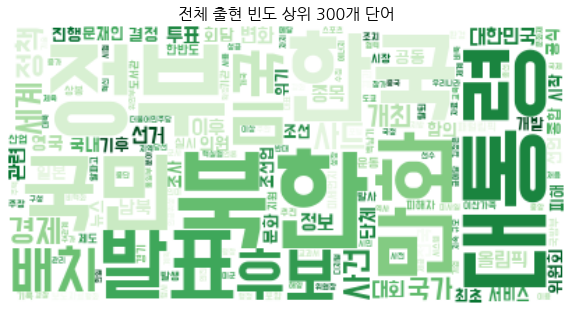

In [159]:
make_wc(all_cont_dict, '전체 출현 빈도 상위 300개 단어', 'Greens')

## 1-2. 주제별 시각화

### 주제별 분포 비율

([<matplotlib.patches.Wedge at 0x20516c03cd0>,
 [Text(-0.11758472681192757, 1.0936973219408395, '사회과학'),
  Text(-0.7495596102084324, -0.8050840892380019, '예술'),
  Text(0.19530866099887825, -1.0825222985873433, '역사'),
  Text(0.74955983634064, -0.8050838787014636, '총류'),
  Text(1.0005952532309026, -0.45695638655323106, '기술과학'),
  Text(1.0748615839135987, -0.23382167441610263, '자연과학'),
  Text(1.09719733692506, -0.0784729497633192, '문학')],
 [Text(-0.06413712371559685, 0.5965621756040942, '53%'),
  Text(-0.40885069647732675, -0.439136775948001, '19%'),
  Text(0.10653199690847903, -0.5904667083203691, '10%'),
  Text(0.40885081982216726, -0.4391366611098892, '8%'),
  Text(0.5457792290350377, -0.2492489381199442, '5%'),
  Text(0.5862881366801447, -0.12753909513605596, '2%'),
  Text(0.5984712746863963, -0.04280342714362865, '2%')])

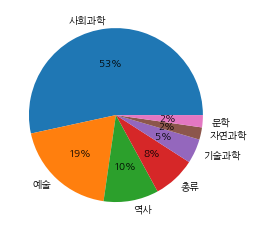

In [10]:
subject_df = pd.DataFrame(columns = ['대주제','count'])
subject_df['대주제']= list(Counter(ori['대주제']).keys())
subject_df['count'] = list(Counter(ori['대주제']).values())
subject_df = subject_df.sort_values(by='count', ascending = False)
plt.pie(subject_df['count'], labels = subject_df['대주제'], autopct = '%0.0f%%')

### 1-2-1. 기술과학

In [8]:
mechanic = ori[ori['대주제'] == '기술과학']
mechanic = filtering(mechanic)
mechanic_dict =  df_to_dict(mechanic[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [9]:
vis_cnt(mechanic[:30], '기술과학 분야 출현빈도 상위 30개 단어')

c:\Users\user\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### (2) 출현 빈도 상위 300개 단어 워드클라우드

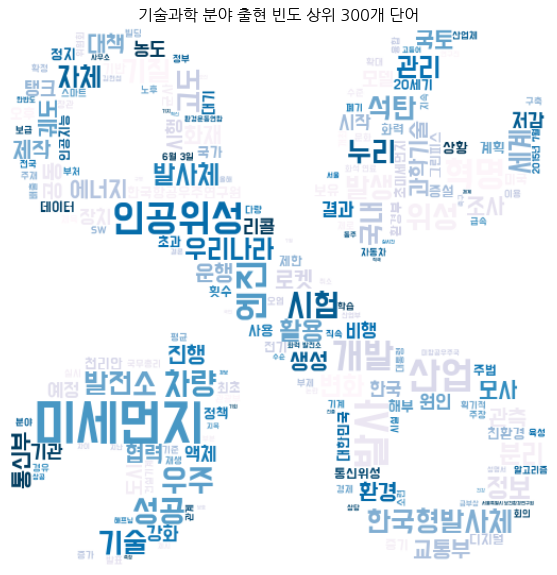

In [23]:
make_wc(mechanic_dict, '기술과학 분야 출현 빈도 상위 300개 단어', 'PuBu',i_me)

### 1-2-2. 자연과학

In [24]:
nature = ori[ori['대주제'] == '자연과학']
nature = filtering(nature)
nature_dict =  df_to_dict(nature[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [25]:
vis_cnt(nature[:30], '자연과학 분야 출현빈도 상위 30개 단어')

c:\Users\user\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### (2) 출현 빈도 상위 300개 단어 워드클라우드

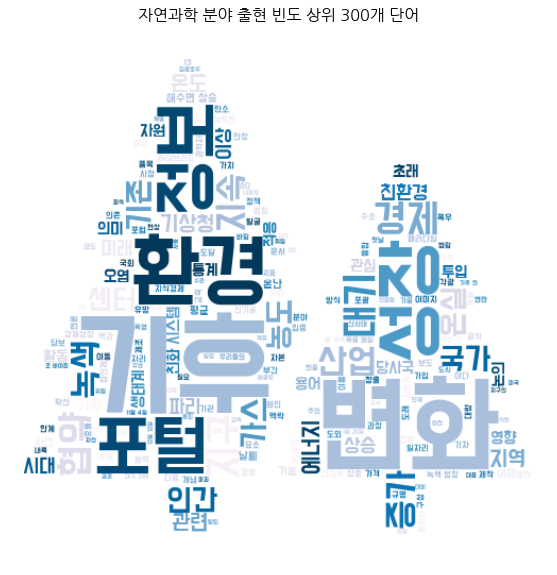

In [26]:
make_wc(nature_dict, '자연과학 분야 출현 빈도 상위 300개 단어', 'PuBu', i_na)

### 1-2-3. 사회과학

In [27]:
social = ori[ori['대주제'] == '사회과학']
social = filtering(social)
social_dict =  df_to_dict(social[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [28]:
vis_cnt(social[:30], '사회과학 분야 출현빈도 상위 30개 단어')

c:\Users\user\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### (2) 출현 빈도 상위 300개 단어 워드클라우드

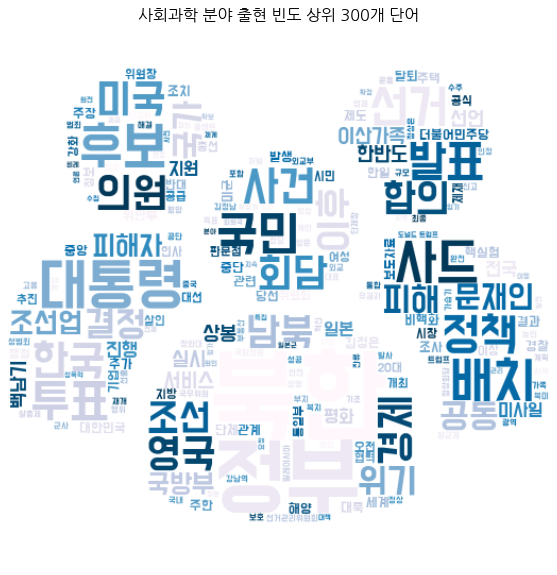

In [49]:
make_wc(social_dict, '사회과학 분야 출현 빈도 상위 300개 단어', 'PuBu',i_ss)

### 1-2-4. 역사 

In [30]:
history = ori[ori['대주제'] == '역사']
history = filtering(history)
history_dict =  df_to_dict(history[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [31]:
vis_cnt(history[:30], '역사 분야 출현빈도 상위 30개 단어')

c:\Users\user\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### (2) 출현 빈도 상위 300개 단어 워드클라우드

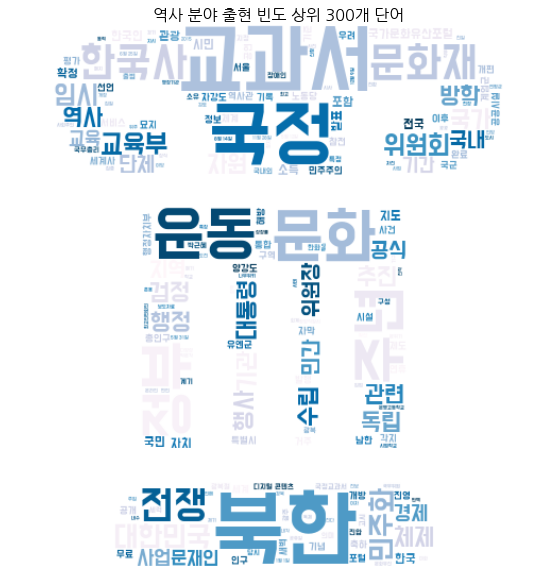

In [32]:
make_wc(history_dict, '역사 분야 출현 빈도 상위 300개 단어', 'PuBu',i_hi)

### 1-2-5. 문학

In [33]:
literate = ori[ori['대주제'] == '문학']
literate = filtering(literate)
literate_dict =  df_to_dict(literate[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [34]:
vis_cnt(literate[:30], '문학 분야 출현빈도 상위 30개 단어')

c:\Users\user\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### (2) 출현 빈도 상위 300개 단어 워드클라우드

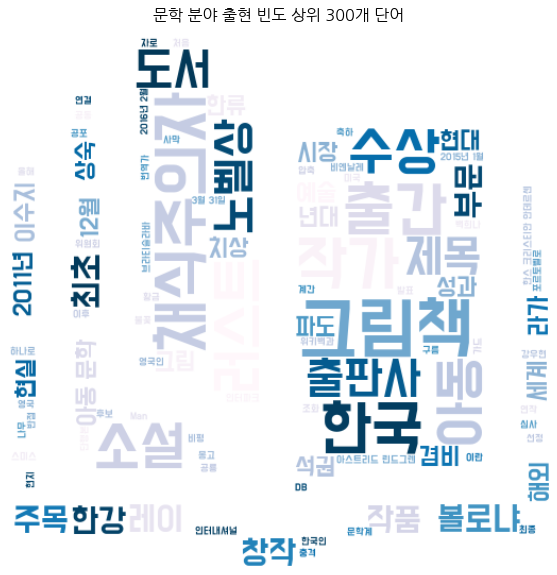

In [43]:
make_wc(literate_dict, '문학 분야 출현 빈도 상위 300개 단어', 'PuBu',i_li)

### 1-2-6. 예술

In [21]:
arts = ori[ori['대주제'] == '예술']
arts = filtering(arts)
arts_dict =  df_to_dict(arts[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [36]:
vis_cnt(arts[:30], '예술 분야 출현빈도 상위 30개 단어')

c:\Users\user\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### (2) 출현 빈도 상위 300개 단어 워드클라우드

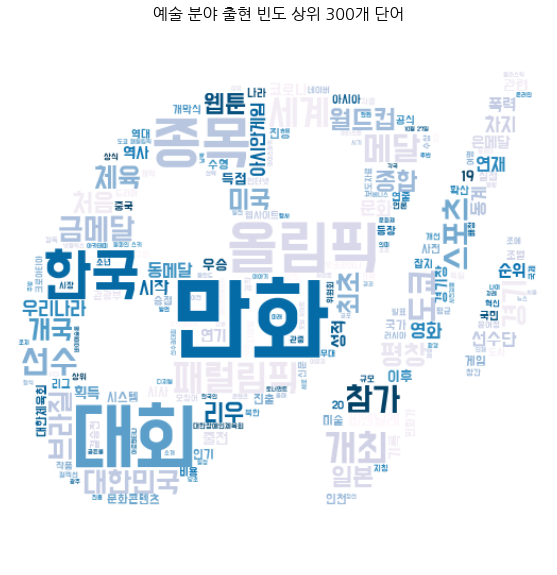

In [48]:
make_wc(arts_dict, '예술 분야 출현 빈도 상위 300개 단어', 'PuBu',i_ar)

### 1-2-7. 총류

In [37]:
gen = ori[ori['대주제'] == '총류']
gen = filtering(gen)
gen_dict =  df_to_dict(gen[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [38]:
vis_cnt(gen[:30], '총류 분야 출현빈도 상위 30개 단어')

c:\Users\user\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### (2) 출현 빈도 상위 300개 단어 워드클라우드

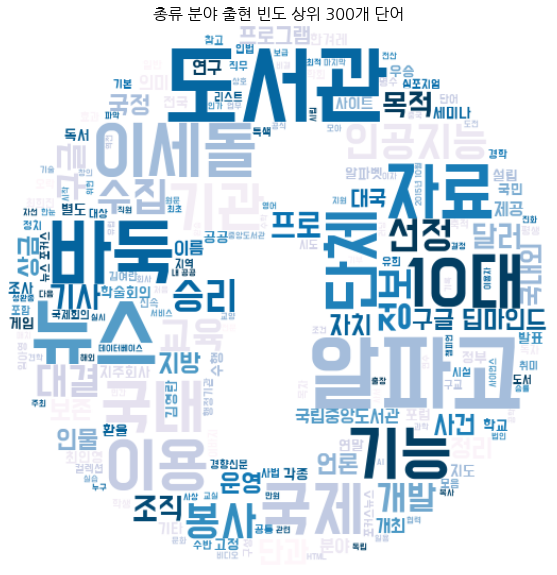

In [47]:
make_wc(gen_dict, '총류 분야 출현 빈도 상위 300개 단어', 'PuBu',i_ge)

# 2. 머신러닝

## 2-1. 토픽모델링

### 2-2-1. K-means 클러스터링
- 비지도 학습, 데이터간 유사성을 바탕으로 학습
- 참고 코드 출처 : https://wonhwa.tistory.com/28 , https://lovit.github.io/nlp/2018/09/27/pyldavis_kmeans/

#### (0) 데이터 전처리 및 벡터화

In [79]:
# 전처리
def before_vectorize(df):
    contents = []
    for cont in df['내용']:
        tokens = kom.nouns(cont)
        getin_tokens = []
        for w in tokens:
            if w not in stopwords:
                getin_tokens.append(w)
        contents.append(getin_tokens)
    text = [' '.join(contents[i]) for i in range(len(contents))]
    return text

# 문장 벡터화
in_text = before_vectorize(ori)
vectorize = CountVectorizer()
vec = vectorize.fit_transform(in_text)
vec = normalize(vec)

# 문장-단어 매트릭스 데이터프레임
vec_df = pd.DataFrame(vec.toarray(), columns = vectorize.get_feature_names_out())

In [229]:
vec_df

,100년,10대,10월,10일,119,11년,11월,11일,12월,12일,...,훼손,휠체어,휴가,흉기,흐름,흡수,흥행,희생,희화,힐러리
0,0.0,0.0,0.000000,0.088388,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.026968,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.048912,0.000000,0.0,0.0,0.048912,0.0,0.048912,0.048912,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.0,0.0,0.000000,0.000000,0.0,0.0,0.065407,0.0,0.032703,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.136717,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
86,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


#### (1) 1차 클러스터 형성 - 7개(사이트 내에서 제시한 분류)

In [208]:
def make_compare_frame(result):
    compare_sub = pd.DataFrame()
    compare_sub['원_대주제'] = ori['대주제']
    compare_sub['kmeans-결과'] = result.labels_
    compare_sub['count'] = 1
    compare_sub2 = compare_sub.groupby(['kmeans-결과','원_대주제']).sum()
    compare_sub2 = compare_sub2.reset_index()

    sub_code = {'사회과학':0, '예술':1, '자연과학':2, '기술과학':3, '역사':4,'총류':5, '문학':6}
    subcodes = []
    for i in range(len(compare_sub2)):
        subcodes.append(sub_code[compare_sub2['원_대주제'][i]])
    compare_sub2['대주제_코드'] = subcodes
    
    return compare_sub2


def make_s_compare_frame(result):
    compare_sub = pd.DataFrame()
    compare_sub['원_대주제'] = ori['대주제']
    compare_sub['kmeans-결과'] = result
    compare_sub['count'] = 1
    compare_sub2 = compare_sub.groupby(['kmeans-결과','원_대주제']).sum()
    compare_sub2 = compare_sub2.reset_index()

    sub_code = {'사회과학':0, '예술':1, '자연과학':2, '기술과학':3, '역사':4,'총류':5, '문학':6}
    subcodes = []
    for i in range(len(compare_sub2)):
        subcodes.append(sub_code[compare_sub2['원_대주제'][i]])
    compare_sub2['대주제_코드'] = subcodes
    
    return compare_sub2

def result_g_kmeans(df, n):
    kmeans = KMeans(n_clusters=n).fit(df)
    comp_df = make_compare_frame(kmeans)
    fig = px.scatter(comp_df,
                 x='kmeans-결과',
                 y='대주제_코드',
                 size= 'count',
                 color='원_대주제',)
    fig.show()

def result_g_sKmeans(df, n):
    # 학습
    spherical_kmeans = SphericalKMeans(
        n_clusters=n,
        max_iter=10,
        verbose=0,
        init='similar_cut',
        sparsity='minimum_df', 
        minimum_df_factor=0.05
    )
    sKmeans = spherical_kmeans.fit_predict(vec)

    # 시각화
    s_comp_df_revised = make_s_compare_frame(sKmeans)
    fig = px.scatter(s_comp_df_revised,
                 x='kmeans-결과',
                 y='대주제_코드',
                 size= 'count',
                 color='원_대주제',)
    fig.show()


__Kmeans__

In [194]:
result_g_kmeans(vec_df, 7)

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



- 예상 : 오아시스에서 분류된 대로 클러스터링 되었을 것으로 예상
- 결과 : 
    - 3번을 위주로 클러스터링 됨 -> 클러스터 개수의 재선정이 필요함
    - 특히 3번의 경우, 기술과학, 자연과학과 같은 인문학이나 사회과학과는 주제적으로 다소 거리가 있는 주제 분야도 섞여 있으므로, 클러스터를 7개로 설정하는 것은 적합하지 않아 보임. 
- 더 적은 수의 클러스터 개수 설정이 필요해 보임


__Spherical Kmeans__

In [199]:
result_g_sKmeans(vec_df, 7)

c:\Users\user\anaconda3\lib\site-packages\soyclustering\_kmeans.py:454: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 

__(+) pyLDAvis로 시각화__

In [195]:
def kmeansToPyLDAvis(n):
    kmeans = KMeans(n_clusters=n).fit(vec_df)
    comp_df = make_compare_frame(kmeans)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    prepared_data = kmeans_to_prepared_data(
        vec, vec_df.columns, centers, labels,
        embedding_method='tsne'
    )
    return pyLDAvis.display(prepared_data)

def sphericalKmean_pyLDAvis(cluster_n):
    # 학습
    spherical_kmeans = SphericalKMeans(
        n_clusters=cluster_n,
        max_iter=10,
        verbose=0,
        init='similar_cut',
        sparsity='minimum_df', 
        minimum_df_factor=0.05
    )

    s_labels = spherical_kmeans.fit_predict(vec)
    s_centers = spherical_kmeans.cluster_centers_

    # 시각화
    prepared_data = kmeans_to_prepared_data(
        vec, vec_df.columns, s_centers, s_labels,
        embedding_method='tsne'
    )
    return pyLDAvis.display(prepared_data)

In [196]:
kmeansToPyLDAvis(7)

c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



__(+)SphericalKmeans 클러스터링 방식 활용 + pyLDAvis__

In [183]:
sphericalKmean_pyLDAvis(7)

c:\Users\user\anaconda3\lib\site-packages\soyclustering\_kmeans.py:454: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 

#### (2) 클러스터 개수 찾기
- 클러스터 개수의 재설정을 위해, 두 가지 방법을 통해 보다 객관적으로 클러스터 개수를 선정하고자 함.
- 참고 : https://nicola-ml.tistory.com/66

##### (2)-1. Elbow method

In [297]:
import math
def visualize_elbowmethod(data, param_init='random', param_n_init=30, param_max_iter=600):
    distortions = []
    for i in range(1, 11):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)

    g1 = go.Line(x = list(range(1,11)), y = distortions)
    layout = go.Layout(title='Kmeans inertia')
    fig = go.Figure(data=g1, layout=layout)
    fig.show()
    dis = {}
    for i in range(1,9): 
        k = distortions[i-1]-distortions[i] *2+ distortions[i+1]
        dis[i] = k # 응집도가 급변하는 개수 구함
    max_dis = max(dis.values())
    for k in dis.keys():
        if dis[k] == max_dis:
            max_key = k+1
    print('optimal number : ' + str(max_key))
    return max_key

def visualize_s_elbowmethod(data, param_init='random', param_n_init=30, param_max_iter=600):
    distortions = []
    for i in range(2, 11):
        spherical_kmeans = SphericalKMeans(
        n_clusters=i,
        max_iter=10,
        verbose=0,
        init='similar_cut',
        sparsity='minimum_df', 
        minimum_df_factor=0.05)
        spherical_kmeans.fit_predict(vec)
        distortions.append(spherical_kmeans.inertia_)
    g1 = go.Line(x = list(range(2,16)), y = distortions)
    layout = go.Layout(title='Spherical Kmeans inertia')
    fig = go.Figure(data=g1, layout=layout)
    fig.show()

    dis = {}
    for i in range(0,8):
        k = distortions[i-1]-distortions[i] *2+ distortions[i+1] 
        dis[i] = k # 응집도가 급변하는 지점 구함 
    max_dis = max(dis.values())
    for k in dis.keys():
        if dis[k] == max_dis:
            print(max_dis)
            max_key = k+2
    print('optimal number : ' + str(max_key))
    return max_key

In [290]:
visualize_elbowmethod(vec_df) # 최적 함수 개수 : 4

c:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\user\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



optimal number : 4


4

- 경사가 급변하는 지점을 찾기 어려워, 사실상 elbow method가 효율적이지 않다.

In [298]:
visualize_s_elbowmethod(vec_df) # 최적 함수 개수 : 6개

c:\Users\user\anaconda3\lib\site-packages\soyclustering\_kmeans.py:454: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 

3.970945444660096
optimal number : 6


6

##### (2)-2. 실루엣 계수 활용(Silhouette Score)
실루엣 분석은 각 군집 간의 거리가 얼마나 효율적으로 분리 돼있는지를 나타낸다. 효율적으로 잘 분리 됐다는 것은 다른 군집과의 거리는 떨어져 있고 동일 군집끼리의 데이터는 서로 가깝게 잘 뭉쳐 있다는 의미이다. 1에 가까울수록 분리가 잘 되어있음을 의미함


__Kmeans__

In [283]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

sil_dict = {}
for i in range(2,11):
    km = KMeans(n_clusters=i,init='random', n_init=30, max_iter=600, random_state = 0)
    km.fit(vec_df)
    sil_score = silhouette_score(vec_df, km.labels_)
    sil_dict[i] = sil_score
max_sil = max(sil_dict.values())
print(max_sil)
for k in sil_dict.keys():
    if sil_dict[k] == max_sil:
        print(k)


g = go.Line(x=list(sil_dict.keys()),  y=list(sil_dict.values()), name ='silhouette Score')
layout = go.Layout(title='Kmeans 실루엣 계수')
fig = go.Figure(data=g, layout=layout)
fig.show()


0.040597840986729215
8


c:\Users\user\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



- 전반적으로 1에 근접한 수는 없음
- 이 중에서 그나마 큰 수 : 8

__SphericalKmeans__

In [299]:
sil_dict = {}
for i in range(2,11):

    spherical_kmeans = SphericalKMeans(
        n_clusters=i,
        max_iter=10,
        verbose=0,
        init='similar_cut',
        sparsity='minimum_df', 
        minimum_df_factor=0.05)

    s_labels = spherical_kmeans.fit_predict(vec)
    s_centers = spherical_kmeans.cluster_centers_

    sil_score = silhouette_score(vec_df, s_labels)
    sil_dict[i] = sil_score

max_sil = max(sil_dict.values())
print(max_sil)
for k in sil_dict.keys():
    if sil_dict[k] == max_sil:
        print(k)


g = go.Line(x=list(sil_dict.keys()),  y=list(sil_dict.values()), name ='silhouette Score')
layout = go.Layout(title='Spherical Kmeans - 실루엣 계수')
fig = go.Figure(data=g, layout=layout)
fig.show()

c:\Users\user\anaconda3\lib\site-packages\soyclustering\_kmeans.py:454: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 

0.0383196448913262
9


c:\Users\user\anaconda3\lib\site-packages\soyclustering\_kmeans.py:454: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 

- 마찬가지로 근접한 수 x
- 그나마 큰 수 : 9

#### (3) 2차 클러스터 형성

##### (3)-1. Elbow 결과로 재형성

__Kmeans__

In [200]:
# elbow method 
result_g_kmeans(vec_df, 4)


c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



__Spherical Kmeans__

In [300]:
result_g_sKmeans(vec_df, 6)

c:\Users\user\anaconda3\lib\site-packages\soyclustering\_kmeans.py:454: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 

##### (3)-1 + PyLDAvis로 시각화

__Kmeans__

In [269]:
kmeansToPyLDAvis(4)

c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



__SphericalKmeans__

In [301]:
# 학습
sphericalKmean_pyLDAvis(6)

c:\Users\user\anaconda3\lib\site-packages\soyclustering\_kmeans.py:454: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 

##### (3)-2 실루엣 계수 결과로 재형성

__Kmeans__

In [303]:
result_g_kmeans(vec_df, 8)

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\user\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



__Spherical Kmeans__

In [302]:
result_g_sKmeans(vec_df, 9)

c:\Users\user\anaconda3\lib\site-packages\soyclustering\_kmeans.py:454: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 

##### (3)-2 + pyLDAvis로 시각화

__Kmeans__

In [304]:
kmeansToPyLDAvis(8)

c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



__SphericalKmeans__

In [305]:
sphericalKmean_pyLDAvis(9)

c:\Users\user\anaconda3\lib\site-packages\soyclustering\_kmeans.py:454: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning:

np.matrix usage is deprecated in 1.0 